Мохляков П.А. \
М8О-408Б-19 \
Вариант 3

## Лабораторная работа 8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import tqdm
from queue import Queue

Создаем класс TDL

In [2]:
class TDL(nn.Module):
    def __init__(self, in_features, delay=2):
        super().__init__()
        self.in_features = in_features
        self.delay = delay
        self.queue = Queue()        
        self.clear()
        
    def clear(self):
        self.queue.queue.clear()
        for _ in range(self.delay):
            self.queue.put(torch.zeros(self.in_features))
    
    def forward(self):
        return self.queue.get()
    
    def put(self, x):
        self.queue.put(x)

Создаем класс NARX

In [3]:
class NARX(nn.Module):
    def __init__(self, in_features, hide_features, out_features, delay1=2, delay2=2):
        super().__init__()
        self.tdl1 = TDL(in_features, delay1)
        self.tdl2 = TDL(out_features, delay2)
        self.linear1 = nn.Linear(in_features, hide_features)
        self.linear2 = nn.Linear(hide_features, out_features)
        self.linear3 = nn.Linear(out_features, hide_features)
        
    def clear(self):
        self.tdl1.clear()
        self.tdl2.clear()
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        self.tdl1.put(x.clone().detach())
        out_tdl1 = self.tdl1()
        out_tdl2 = self.tdl2()
        out_line1 = self.linear1(out_tdl1)
        out_line3 = self.linear3(out_tdl2)
        tanh = nn.Tanh()
        out_tanh = tanh(out_line1 + out_line3)
        out = self.linear2(out_tanh)
        self.tdl2.put(out.clone().detach())
        return out

Входные данные

In [4]:
N = 500
window = 5
t = np.linspace(0, 5, N)
Uy = [np.sin(-3*k**2 + 10*k - 5) for k in t]
y = [0]
for i in range(N-1):
    y.append(y[i] / (1 + y[i]**2) + Uy[i]**3)

train_data = [(np.array(Uy[i:i+window], dtype=np.float32), np.array(y[i:i+window], dtype=np.float32)) for i in range(N-window)]

train_dataloader = DataLoader(train_data, shuffle=False, batch_size=1)

Создаем и тренеруем модель

In [5]:
model = NARX(window, 20, window, 3, 3)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epoch = 200

model.train()

loses = []
for ep in tqdm.tqdm(range(epoch)):
    epoch_loss = []
    for (inp, out) in train_dataloader: 
        pred = model(inp)
        loss = loss_fn(pred, out)
        epoch_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loses.append(np.mean(epoch_loss))

  0%|          | 0/200 [00:00<?, ?it/s]/home/pavel/Neuroinformatics/ENV/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


График ошибки

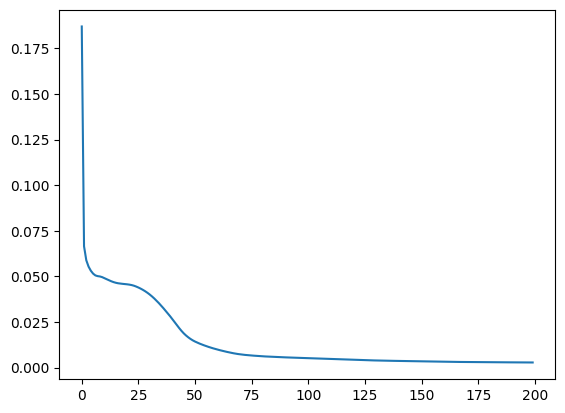

In [7]:
plt.plot(loses)

Строим предсказание и сравниваем

In [8]:
model.clear()
model.eval()

NARX(
  (tdl1): TDL()
  (tdl2): TDL()
  (linear1): Linear(in_features=5, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=5, bias=True)
  (linear3): Linear(in_features=5, out_features=20, bias=True)
)

In [9]:
ans = [data[1][window//2] for data in train_data]
pred = [model(data[0])[window//2].detach().numpy() for data in train_data]
inp = Uy[window//2: -window//2]

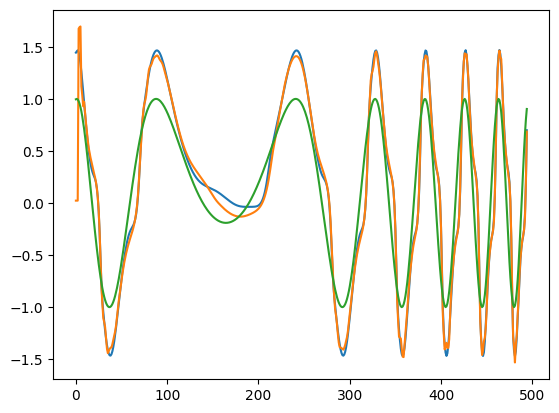

In [10]:
plt.plot(ans)
plt.plot(pred)
plt.plot(inp)